## Load modules & data

In [1]:
#Base
from glob import glob
import sys, os, pdb
import numpy as np
import xarray as xr
import pandas as pd
import scipy.stats as st
from scipy.spatial import KDTree
from tqdm.notebook import trange, tqdm

#Plot
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import matplotlib.gridspec as gridspec

#V1DD
from allen_v1dd.client import OPhysClient, EMClient
from allen_v1dd.stimulus_analysis import analysis_tools as at
at.set_stylesheet()

# EM-coregistration Github
# https://github.com/RussTorres/em_coregistration/tree/rmt_working_branch
sys.path.append('/home/david.wyrick/Git/em_coregistration/')
import coregister
import coregister.transform
import coregister.data_loader
from coregister.process.affine_matrices import transform_pts
from coregister.process.roi import center_from_pix_mask
from coregister.io.read_nwb import ROI_mask_nwb

%matplotlib inline
%load_ext autoreload
%autoreload 2

color_names=['amber','red','windows blue','faded green',
             'dusty purple',
             'orange',
             'steel blue',
             'pink',
             'greyish',
             'mint',
             'clay',
             'light cyan',
             'forest green',
             'pastel purple',
             'salmon',
             'dark brown',
             'lavender',
             'pale green',
             'dark red',
             'gold',
             'dark teal',
             'rust',
             'fuchsia',
             'pale orange',
             'cobalt blue',
             'mahogany',
             'cloudy blue',
             'dark pastel green',
             'dust',
             'electric lime',
             'fresh green',
             'light eggplant',
             'nasty green']
 
color_palette = sns.xkcd_palette(color_names)
cc = sns.xkcd_palette(color_names)
em_final_voxel_size = np.array([4.85, 4.85, 45])

PlotDir = '/home/david.wyrick/projects/V1DD/coregistration/plots'

from nglui import statebuilder # generate links in Seung lab a custom Neuroglancer deployment called Neuromancer

def get_array_subset_indices(set_arr, subset_arr):
    set_arr_sorted = np.argsort(set_arr)
    subset_arr_pos = np.searchsorted(set_arr[set_arr_sorted], subset_arr)
    indices = set_arr_sorted[subset_arr_pos]
    return indices


In [2]:
em_client = EMClient.init_microns(datastack_name="minnie65_public_v661")
em_client.get_tables()

['baylor_gnn_cell_type_fine_model_v2',
 'nucleus_alternative_points',
 'connectivity_groups_v507',
 'proofreading_status_public_release',
 'allen_column_mtypes_v1',
 'allen_v1_column_types_slanted_ref',
 'aibs_column_nonneuronal_ref',
 'nucleus_ref_neuron_svm',
 'aibs_soma_nuc_exc_mtype_preds_v117',
 'baylor_log_reg_cell_type_coarse_v1',
 'apl_functional_coreg_forward_v5',
 'nucleus_detection_v0',
 'aibs_soma_nuc_metamodel_preds_v117']

In [3]:
## Load EM data
nucleus_ref_neuron_svm = em_client.query_table('nucleus_ref_neuron_svm')
coreg_df = em_client.query_table('apl_functional_coreg_forward_v5')
nucleus_table = em_client.query_table('nucleus_detection_v0')

#Extract point position 
nucleus_pts = np.array([i for i in nucleus_ref_neuron_svm.pt_position])
coarse_celltype = np.array([i for i in nucleus_ref_neuron_svm.cell_type])
nucleus_ids = np.array([i for i in nucleus_ref_neuron_svm.id_ref])
nucleus_ref_neuron_svm

Table Owner Notice on nucleus_ref_neuron_svm: Please cite https://doi.org/10.1101/2022.07.20.499976 when using this table.


,id_ref,created_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,id,created,valid,target_id,classification_system,cell_type,pt_position,bb_start_position,bb_end_position
0,348209,2020-09-28 22:42:58.127673+00:00,t,78.792786,92423916840203243,864691134945836023,1,2023-03-19 17:46:12.520071+00:00,t,348209,is_neuron,not-neuron,"[803712.0, 1130048.0, 668680.0]","[nan, nan, nan]","[nan, nan, nan]"
1,462557,2020-09-28 22:42:41.050418+00:00,t,62.717788,101417167182010351,864691135294515893,2,2023-03-19 17:46:12.520909+00:00,t,462557,is_neuron,not-neuron,"[1065216.0, 715328.0, 1008000.0]","[nan, nan, nan]","[nan, nan, nan]"
2,266849,2020-09-28 22:43:55.569707+00:00,t,178.954076,88330641678196634,864691136619535757,3,2023-03-19 17:46:12.521719+00:00,t,266849,is_neuron,not-neuron,"[684736.0, 776512.0, 803280.0]","[nan, nan, nan]","[nan, nan, nan]"
3,485509,2020-09-28 22:41:05.119717+00:00,t,348.351529,103588564537113366,864691136740606812,4,2023-03-19 17:46:12.522554+00:00,t,485509,is_neuron,neuron,"[1130432.0, 415232.0, 812720.0]","[nan, nan, nan]","[nan, nan, nan]"
4,481358,2020-09-28 22:41:56.352822+00:00,t,27.511194,0,0,5,2023-03-19 17:46:12.523288+00:00,t,481358,is_neuron,not-neuron,"[1147520.0, 270144.0, 1002600.0]","[nan, nan, nan]","[nan, nan, nan]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144115,256280,2020-09-28 22:43:53.850893+00:00,t,354.738012,87546415009833381,864691135495249040,144116,2023-03-19 17:53:24.168939+00:00,t,256280,is_neuron,neuron,"[663232.0, 473024.0, 807920.0]","[nan, nan, nan]","[nan, nan, nan]"
144116,258113,2020-09-28 22:43:32.150344+00:00,t,355.082076,88181726572292650,864691135889739145,144117,2023-03-19 17:53:24.169602+00:00,t,258113,is_neuron,neuron,"[681280.0, 531968.0, 809000.0]","[nan, nan, nan]","[nan, nan, nan]"
144117,258355,2020-09-28 22:41:35.026623+00:00,t,177.375805,88042363741612639,864691135937582340,144118,2023-03-19 17:53:24.170333+00:00,t,258355,is_neuron,neuron,"[677824.0, 572672.0, 882280.0]","[nan, nan, nan]","[nan, nan, nan]"
144118,256602,2020-09-28 22:41:40.109977+00:00,t,193.776845,87969795974184791,864691135737905540,144119,2023-03-19 17:53:24.171316+00:00,t,256602,is_neuron,neuron,"[674048.0, 507584.0, 882920.0]","[nan, nan, nan]","[nan, nan, nan]"


In [4]:
volume_thresh = 150
nAll = len(nucleus_ref_neuron_svm)
nNeurons = len(nucleus_ref_neuron_svm.loc[(nucleus_ref_neuron_svm.cell_type == 'neuron')])
nNotNeurons = nAll - nNeurons

print('{:.1f}% of neurons miss cutoff'.format(len(nucleus_ref_neuron_svm.loc[(nucleus_ref_neuron_svm.cell_type == 'neuron') & (nucleus_ref_neuron_svm.volume < volume_thresh)])*100/nAll))
print('{:.1f}% of non-neurons make cutoff'.format(len(nucleus_ref_neuron_svm.loc[(nucleus_ref_neuron_svm.cell_type == 'not-neuron') & (nucleus_ref_neuron_svm.volume > volume_thresh)])*100/nAll))
print('{} points removed'.format(len(nucleus_ref_neuron_svm.loc[(nucleus_ref_neuron_svm.cell_type == 'not-neuron') & (nucleus_ref_neuron_svm.volume < volume_thresh)])))


2.9% of neurons miss cutoff
4.7% of non-neurons make cutoff
48229 points removed


neuron: 89059 cells, 61.8%
not-neuron: 55061 cells, 38.2%


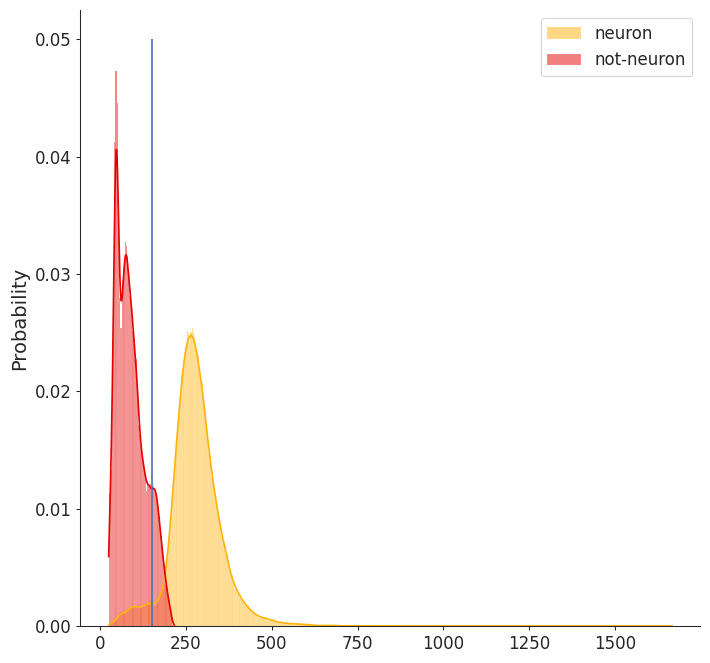

In [36]:
stat = 'probability'
cell_types = np.unique(nucleus_ref_neuron_svm['cell_type'])
cell_types

fig, ax = plt.subplots(figsize=(8,8))


for i,ct in enumerate(cell_types):
    # ct = cell_types[-1*(i+1)]
    sub_df = nucleus_ref_neuron_svm.loc[nucleus_ref_neuron_svm.cell_type == ct]
    print(f'{ct}: {len(sub_df)} cells, {len(sub_df)*100/len(nucleus_ref_neuron_svm):.1f}%')
    g = sns.histplot(sub_df['volume'].values,ax=ax,color=cc[i],kde=True,alpha=0.5,stat=stat,label=ct)

ax.legend()
ax.vlines(volume_thresh,0,0.05)

In [6]:
tmp_df = em_client.query_table('aibs_soma_nuc_metamodel_preds_v117')
cell_types = np.unique(tmp_df['cell_type'])
cell_types

array(['23P', '4P', '5P-ET', '5P-IT', '5P-NP', '6P-CT', '6P-IT', 'BC',
       'BPC', 'MC', 'NGC', 'OPC', 'astrocyte', 'microglia', 'oligo',
       'pericyte'], dtype=object)

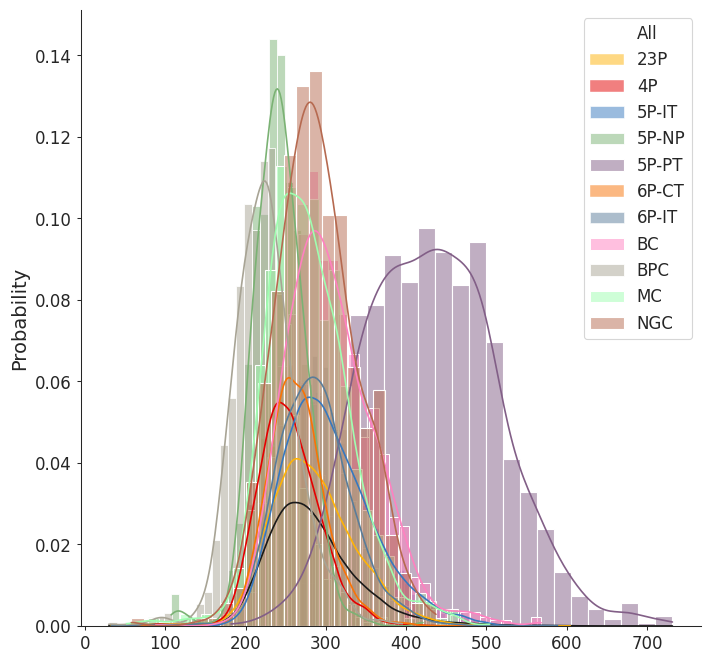

In [41]:
stat = 'probability'; handles = []; labels = []
fig, ax = plt.subplots(figsize=(8,8))

g = sns.histplot(tmp_df['volume'].values,ax=ax,color='k',kde=True,alpha=0,stat=stat,label='All')
handles.append(g); labels.append('All')
# sns.kdeplot(nucleus_ref_neuron_svm['volume'].values,ax=ax,color='k')

for i,ct in enumerate(cell_types):
    # ct = cell_types[-1*(i+1)]
    sub_df = tmp_df.loc[tmp_df.cell_type == ct]
    g = sns.histplot(sub_df['volume'].values,ax=ax,color=cc[i],kde=True,alpha=0.5,stat=stat,label=ct)

ax.legend()

In [7]:
em_client.get_tables()

['baylor_gnn_cell_type_fine_model_v2',
 'nucleus_alternative_points',
 'connectivity_groups_v507',
 'proofreading_status_public_release',
 'allen_column_mtypes_v1',
 'allen_v1_column_types_slanted_ref',
 'aibs_column_nonneuronal_ref',
 'nucleus_ref_neuron_svm',
 'aibs_soma_nuc_exc_mtype_preds_v117',
 'baylor_log_reg_cell_type_coarse_v1',
 'apl_functional_coreg_forward_v5',
 'nucleus_detection_v0',
 'aibs_soma_nuc_metamodel_preds_v117']

array(['23P', '4P', '5P-ET', '5P-IT', '5P-NP', '6P-CT', '6P-IT', 'BC',
       'BPC', 'MC', 'NGC', 'OPC', 'astrocyte', 'microglia', 'oligo',
       'pericyte'], dtype=object)

excitatory: 49208 cells, 89.4%
inhibitory:  5855 cells, 10.6%


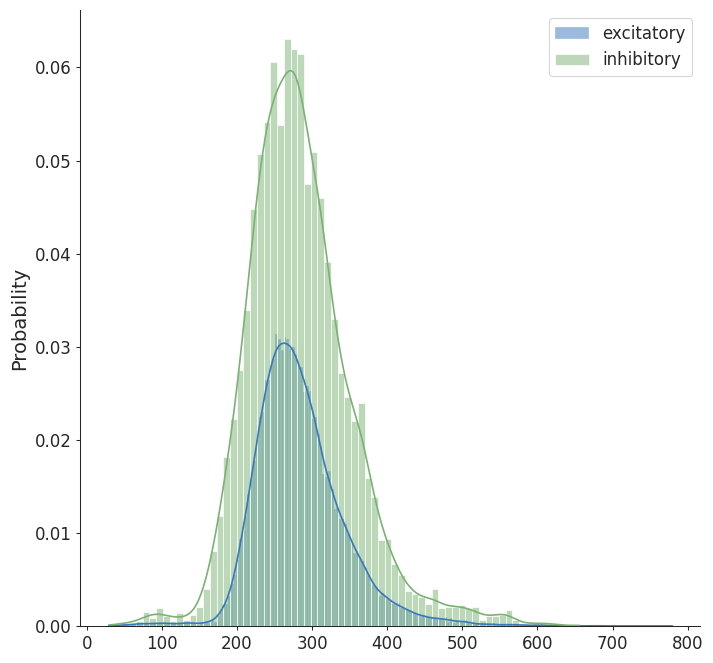

In [35]:
tmp_df = em_client.query_table('baylor_log_reg_cell_type_coarse_v1')
cell_types = np.unique(tmp_df['cell_type'])

fig, ax = plt.subplots(figsize=(8,8))
for i,ct in enumerate(cell_types):
    # ct = cell_types[-1*(i+1)]
    sub_df = tmp_df.loc[tmp_df.cell_type == ct]
    print(f'{ct}: {len(sub_df):5d} cells, {len(sub_df)*100/len(tmp_df):.1f}%')
    g = sns.histplot(sub_df['volume'].values,ax=ax,color=cc[i+2],kde=True,alpha=0.5,stat=stat,label=ct)

ax.legend()
# ax.vlines(volume_thresh,0,0.05)

23P: 18689 cells, 38.1%
4P:  7391 cells, 15.1%
5P-IT:  7433 cells, 15.2%
5P-NP:   514 cells, 1.0%
5P-PT:  1219 cells, 2.5%
6P-CT:  4972 cells, 10.1%
6P-IT:  4943 cells, 10.1%
BC:  1424 cells, 2.9%
BPC:   946 cells, 1.9%
MC:   984 cells, 2.0%
NGC:   536 cells, 1.1%


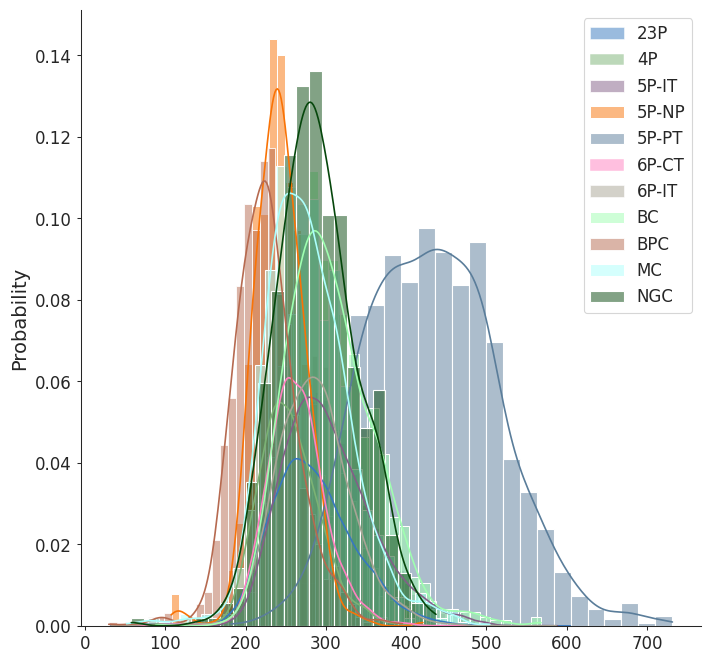

In [33]:
tmp_df = em_client.query_table('baylor_gnn_cell_type_fine_model_v2')
cell_types = np.unique(tmp_df['cell_type'])

fig, ax = plt.subplots(figsize=(8,8))
for i,ct in enumerate(cell_types):
    # ct = cell_types[-1*(i+1)]
    sub_df = tmp_df.loc[tmp_df.cell_type == ct]
    print(f'{ct}: {len(sub_df):5d} cells, {len(sub_df)*100/len(tmp_df):.1f}%')
    g = sns.histplot(sub_df['volume'].values,ax=ax,color=cc[i+2],kde=True,alpha=0.5,stat=stat,label=ct)

ax.legend()

23P: 19139 cells, 22.0%
4P: 13407 cells, 15.4%
5P-ET: 1626 cells, 1.9%
5P-IT: 9060 cells, 10.4%
5P-NP: 456 cells, 0.5%
6P-CT: 5862 cells, 6.7%
6P-IT: 10746 cells, 12.4%
BC: 3084 cells, 3.5%
BPC: 1424 cells, 1.6%
MC: 2270 cells, 2.6%
NGC: 651 cells, 0.7%
OPC: 2483 cells, 2.9%
astrocyte: 7724 cells, 8.9%
microglia: 3024 cells, 3.5%
oligo: 4998 cells, 5.8%
pericyte: 962 cells, 1.1%


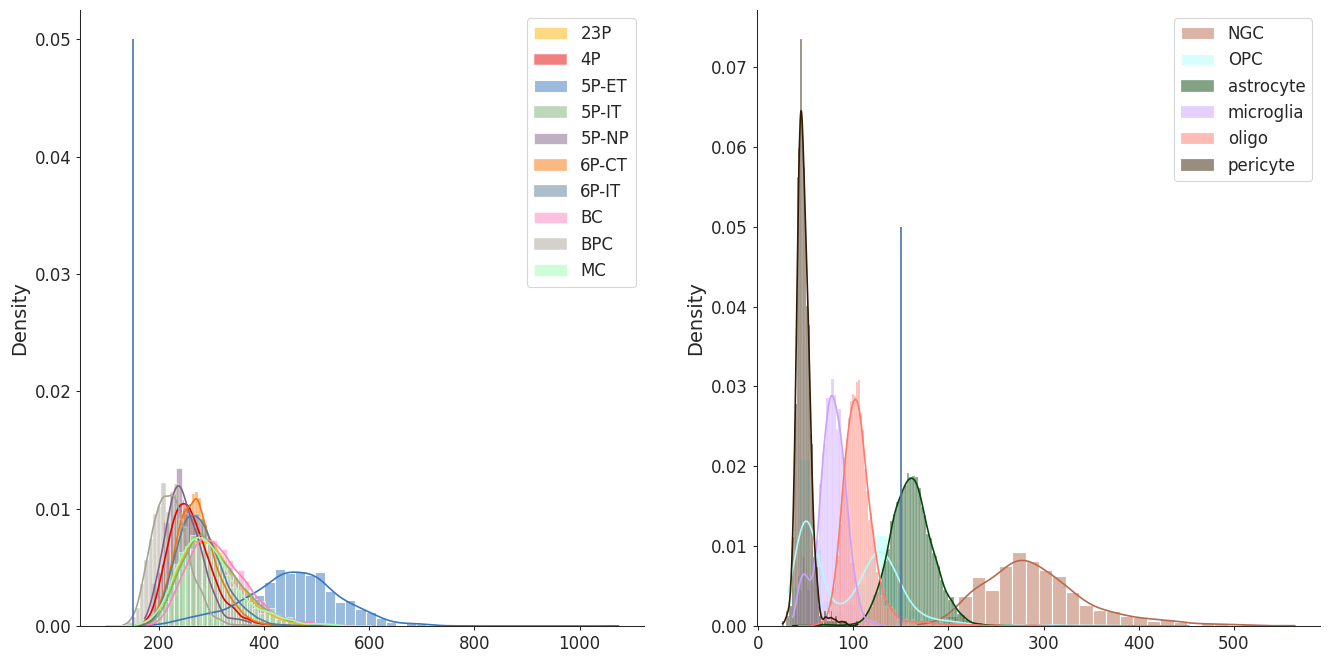

In [34]:
tmp_df = em_client.query_table('aibs_soma_nuc_metamodel_preds_v117')
cell_types = np.unique(tmp_df['cell_type'])

fig, axes = plt.subplots(1,2,figsize=(16,8))
for i, ct in enumerate(cell_types[:10]):
    sub_df = tmp_df.loc[tmp_df.cell_type == ct]
    print(f'{ct}: {len(sub_df)} cells, {len(sub_df)*100/len(tmp_df):.1f}%')
    sns.histplot(sub_df['volume'].values,ax=axes[0],kde=True,color=cc[i],alpha=0.5,stat='density',label=ct)
axes[0].legend()
axes[0].vlines(volume_thresh,0,0.05)
for i, ct in enumerate(cell_types[10:]):
    sub_df = tmp_df.loc[tmp_df.cell_type == ct]
    print(f'{ct}: {len(sub_df)} cells, {len(sub_df)*100/len(tmp_df):.1f}%')
    sns.histplot(sub_df['volume'].values,ax=axes[1],kde=True,color=cc[i+10],alpha=0.5,stat='density',label=ct)
axes[1].legend()
axes[1].vlines(volume_thresh,0,0.05)

## Construct 3D grid of EM data

In [22]:
# How many cells are within a volume specified by grid_size?
grid_size = 32
scalar = 1E3

em_xyz_min = np.min(nucleus_pts,axis=0)
em_xyz_max = np.max(nucleus_pts,axis=0)

em_volume_nm = em_xyz_max-em_xyz_min
grid_cellnum = np.round(em_volume_nm/scalar/grid_size)
print(em_volume_nm/scalar,'microns')
print('# of grids per dimension: ',grid_cellnum)

[1510.4    978.752  521.48 ] microns
# of grids per dimension:  [47. 31. 16.]


In [27]:
# Match cells used for creating co-registration transform to nucleus location 
em_kdt_allcells = KDTree(nucleus_pts)
neuron_pts = nucleus_pts[neuron_mask]
em_kdt_neurons = KDTree(neuron_pts)

grid_boundaries = [np.arange(em_xyz_min[i],em_xyz_max[i],grid_size*scalar) for i in range(3)]

nCells_per_grid = np.zeros([len(g) for g in grid_boundaries])
nNeurons_per_grid = np.zeros([len(g) for g in grid_boundaries])

for iX, x_bound in enumerate(grid_boundaries[0]):
    for iY, y_bound in enumerate(grid_boundaries[1]):
        for iZ, z_bound in enumerate(grid_boundaries[2]):
            #Get grid boundaries and center
            grid_xyz_min = np.array([x_bound,y_bound,z_bound])
            grid_xyz_max = grid_xyz_min + grid_size*scalar
            grid_xyz_ctr = grid_xyz_min + grid_size*scalar/2

            #Use center to query em table
            distances, indices = em_kdt_allcells.query(grid_xyz_ctr, k=100)
            
            #Of these 100 cells, how many are within the grid volume?
            nPts = np.sum((np.all(nucleus_pts[indices] >= grid_xyz_min,axis=1)) & (np.all(nucleus_pts[indices] < grid_xyz_max,axis=1)))
            nCells_per_grid[iX,iY,iZ] = nPts

            #Use center to query em table
            distances, indices = em_kdt_neurons.query(grid_xyz_ctr, k=100)

            #Of these 100 neurons, how many are within the grid volume?
            nPts = np.sum((np.all(neuron_pts[indices] >= grid_xyz_min,axis=1)) & (np.all(neuron_pts[indices] < grid_xyz_max,axis=1)))
            nNeurons_per_grid[iX,iY,iZ] = nPts

            # if nPts > 0:
            #     indy = indices[(np.all(nucleus_pts[indices] >= grid_xyz_min,axis=1)) & (np.all(nucleus_pts[indices] < grid_xyz_max,axis=1))]
            #     nucleus_ids_in_grid = nucleus_ids[indy]


In [28]:
#If we did this right, the total sum of "nCells_per_grid" should be equal to the # of em pts in the table
np.sum(nCells_per_grid.ravel()) == len(nucleus_table)

True

In [33]:
nNonNeurons_per_grid.ravel()

array([0., 0., 0., ..., 0., 0., 0.])

In [30]:
nNonNeurons_per_grid = nCells_per_grid - nNeurons_per_grid

Text(0, 0.5, 'Counts')

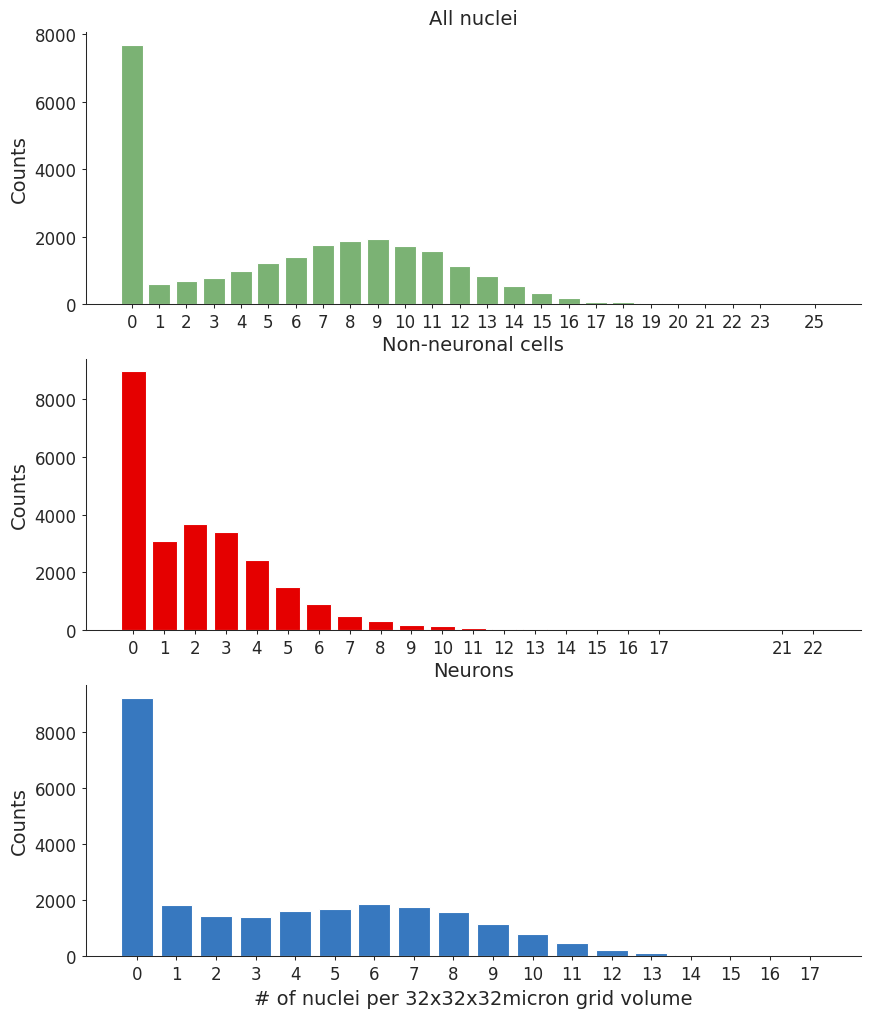

In [38]:
fig, axes = plt.subplots(3,1,figsize=(10,12))


ax = axes[0]; ax.set_title('All nuclei')
cc,tt = np.unique(nCells_per_grid.ravel(),return_counts=True)
# sns.barplot(cc, tt,ax=ax)
ax.bar(cc, tt,color=color_palette[3])
ax.set_xticks(cc)
# ax.set_xlabel(f'# of nuclei per {grid_size}x{grid_size}x{grid_size}micron grid volume')
ax.set_ylabel('Counts')

ax = axes[1];ax.set_title('Non-neuronal cells')
cc,tt = np.unique(nNonNeurons_per_grid.ravel(),return_counts=True)
# sns.barplot(cc, tt,ax=ax)
ax.bar(cc, tt,color=color_palette[1])
ax.set_xticks(cc)
# ax.set_xlabel(f'# of em non-neuronal nuclei per {grid_size}x{grid_size}x{grid_size}micron grid volume')
ax.set_ylabel('Counts')

ax = axes[2];ax.set_title('Neurons')
cc,tt = np.unique(nNeurons_per_grid.ravel(),return_counts=True)
# sns.barplot(cc, tt,ax=ax)
ax.bar(cc, tt,color=color_palette[2])
ax.set_xticks(cc)
ax.set_xlabel(f'# of nuclei per {grid_size}x{grid_size}x{grid_size}micron grid volume')
ax.set_ylabel('Counts')